In [1]:
import numpy as np

X_train = np.load('../data/processed/train.npz')['x']
y_train = np.load('../data/processed/train.npz')['y']
X_v = np.load('../data/processed/v.npz')['x']
y_v = np.load('../data/processed/v.npz')['y']

In [2]:
import json
import xgboost as xgb

import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))

from src.utils.amex_metric import *

with open('../config/xgboost.json', 'r') as f:
    params = json.load(f)
dtrain = xgb.DMatrix(X_train, y_train)
dv = xgb.DMatrix(X_v, y_v)

bst = xgb.train(params, dtrain, num_boost_round=9999, verbose_eval=0,
                evals=[(dtrain, 'train'), (dv, 'v')], custom_metric=amex_scorer, 
                early_stopping_rounds=100, maximize=True)
print(amex_metric(y_v, bst.predict(dv, iteration_range=(0, bst.best_iteration + 1))))

0.9198864841934796


In [3]:
# Feature importances --> top feature as same importance as bottom 100 features
import pandas as pd

dict_gain = bst.get_score(importance_type='gain')
dict_weight = bst.get_score(importance_type='weight')
df_importance = pd.DataFrame({'feature': dict_gain.keys(),
                              'gain': dict_gain.values(),
                              'weight': dict_weight.values()})
df_importance.sort_values(by='gain', ascending=False)

,feature,gain,weight
0,f0,1383.492798,741.0
17,f17,759.400513,210.0
14,f14,520.265686,40.0
24,f24,485.854004,228.0
10,f10,477.549103,172.0
...,...,...,...
96,f96,6.200300,6.0
172,f175,5.418214,2.0
124,f126,5.393435,1.0
104,f104,5.348720,1.0


In [5]:
'''
# Forgetting events
forget = pd.read_csv('../outputs/results/forget.csv')['0']
learnt = pd.read_csv('../outputs/results/learnt.csv')['0']

%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt

plt.rc('font', family='serif')
plt.rc('axes', grid=True)
plt.rcParams['grid.color'] = (0.5, 0.5, 0.5, 0.2)
plt.rc('ytick', direction='out', color='gray')
plt.rc('xtick', direction='out', color='gray')
plt.rcParams.update({'font.size': 12})

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.hist(forget, bins=range(int(max(forget))), edgecolor='dimgray', color='lightskyblue', align='left', lw=0.2)
ax.set_ylim((0, 7000))
ax.set_xlabel('Number of forgetting events')
ax.set_ylabel('Count')
ax.grid(axis='x')
fig.savefig('../outputs/figures/forget_hist.pdf', dpi=300, bbox_inches='tight')
'''

"\n# Forgetting events\nforget = pd.read_csv('../outputs/results/forget.csv')['0']\nlearnt = pd.read_csv('../outputs/results/learnt.csv')['0']\n\n%config InlineBackend.figure_format = 'svg'\nimport matplotlib.pyplot as plt\n\nplt.rc('font', family='serif')\nplt.rc('axes', grid=True)\nplt.rcParams['grid.color'] = (0.5, 0.5, 0.5, 0.2)\nplt.rc('ytick', direction='out', color='gray')\nplt.rc('xtick', direction='out', color='gray')\nplt.rcParams.update({'font.size': 12})\n\nfig, ax = plt.subplots(1, 1, figsize=(7, 5))\nax.hist(forget, bins=range(int(max(forget))), edgecolor='dimgray', color='lightskyblue', align='left', lw=0.2)\nax.set_ylim((0, 7000))\nax.set_xlabel('Number of forgetting events')\nax.set_ylabel('Count')\nax.grid(axis='x')\nfig.savefig('../outputs/figures/forget_hist.pdf', dpi=300, bbox_inches='tight')\n"

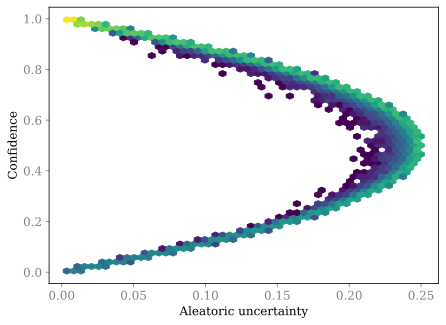

In [7]:
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt

plt.rc('font', family='serif')
plt.rc('axes', grid=True)
plt.rcParams['grid.color'] = (0.5, 0.5, 0.5, 0.2)
plt.rc('ytick', direction='out', color='gray')
plt.rc('xtick', direction='out', color='gray')
plt.rcParams.update({'font.size': 12})

# DataIQ
uncertainty = pd.read_csv('../outputs/results/aleatoric.csv')['0']
confidence = pd.read_csv('../outputs/results/confidence.csv')['0']

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.hexbin(uncertainty, confidence, mincnt=1, bins='log', gridsize=50)
ax.set_xlabel('Aleatoric uncertainty')
ax.set_ylabel('Confidence')
plt.grid(False)
fig.savefig('../outputs/figures/unc_vs_conf.pdf', dpi=300, bbox_inches='tight')

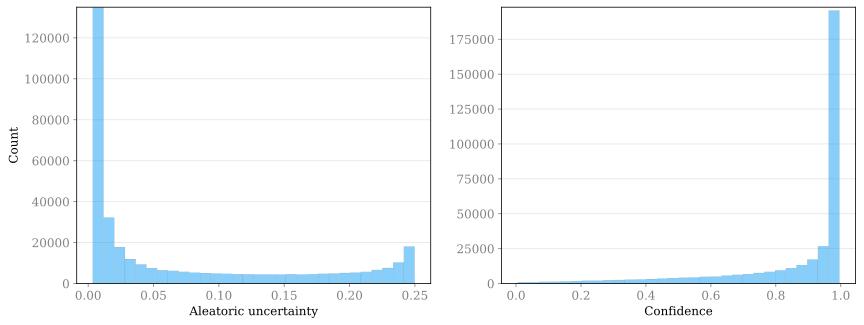

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].hist(uncertainty, bins=30, edgecolor='dimgray', color='lightskyblue', lw=0.1)
axes[0].set_xlabel('Aleatoric uncertainty')
axes[0].set_ylabel('Count')
axes[0].grid(axis='x')
axes[0].set_ylim((0, 135000))
axes[1].hist(confidence, bins=30, edgecolor='dimgray', color='lightskyblue', lw=0.1)
axes[1].set_xlabel('Confidence')
axes[1].grid(axis='x')
axes[1].set_ylim((0, 198000))
fig.savefig('../outputs/figures/dataiq_hist.pdf', dpi=300, bbox_inches='tight')

In [9]:
# Divide in Hard/Easy/Ambiguous
uncertainty_thresh = 0.2
thresh = 0.25
conf_thresh_low = thresh
conf_thresh_high = 1 - thresh
conf_thresh = 0.5

hard_train = np.where((confidence <= conf_thresh_low) & (uncertainty <= uncertainty_thresh))[0]
easy_train = np.where((confidence >= conf_thresh_high) & (uncertainty <= uncertainty_thresh))[0]

hard_easy = np.concatenate((hard_train, easy_train))
ambig_train = []
for id in range(len(confidence)):
    if id not in hard_easy:
        ambig_train.append(id)
ambig_train = np.array(ambig_train)

In [10]:
print(len(hard_train)) # Very few hard points --> overconfidence problem
print(len(easy_train))
print(len(ambig_train))

10499
284902
63512


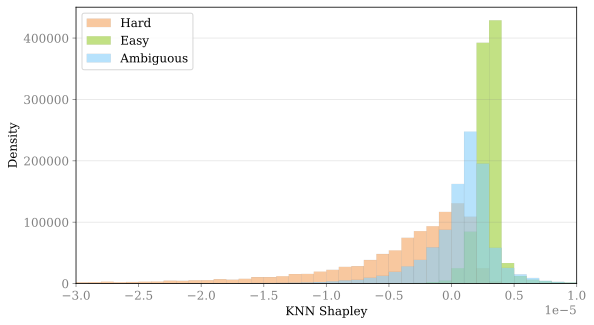

In [21]:
knn = pd.read_csv('../outputs/results/knn_100.csv')['0']
knn_hard = knn[hard_train]
knn_easy = knn[easy_train]
knn_ambig = knn[ambig_train]

fig, ax = plt.subplots(1, 1, figsize=(9, 5))
min_v, max_v = -0.00003, 0.00001
bin_width = (max_v - min_v) / 40
bin_edges = np.arange(min_v, max_v + bin_width, bin_width)
ax.hist(knn_hard, label='Hard', density=True, edgecolor='dimgray', color='sandybrown', lw=0.1, alpha=0.6, bins=bin_edges)
ax.hist(knn_easy, label='Easy', density=True, edgecolor='dimgray', color='yellowgreen', lw=0.1, alpha=0.6, bins=bin_edges)
ax.hist(knn_ambig, label='Ambiguous', density=True, edgecolor='dimgray', color='lightskyblue', lw=0.1, alpha=0.6, bins=bin_edges)
ax.legend(loc='upper left')
ax.grid(axis='x')
ax.set_xlim((-0.00003, 0.00001))
ax.set_xlabel('KNN Shapley')
ax.set_ylabel('Density')
fig.savefig('../outputs/figures/knn_vs_dataiq_hist.pdf', dpi=300, bbox_inches='tight')

In [12]:
y_hard = y_train[hard_train]
y_easy = y_train[easy_train]
y_ambig = y_train[ambig_train]

X_hard = X_train[hard_train]
X_easy = X_train[easy_train]
X_ambig = X_train[ambig_train]

print(y_hard.sum() / len(y_hard)) # High amount of defaulters
print(y_easy.sum() / len(y_easy)) # Mostly non-defaulters
print(y_ambig.sum() / len(y_ambig)) # High amount of defaulters

0.587294028002667
0.1906690721721855
0.5108798337322081


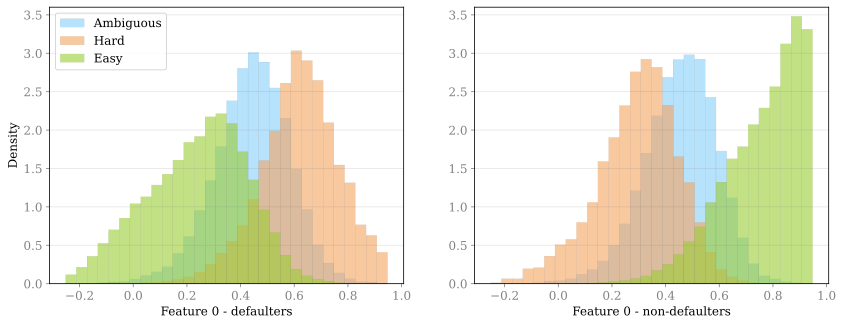

In [25]:
# Consider the top 2 features (minus outliers)
ambig_def = X_ambig[y_ambig == 1, :]
easy_def = X_easy[y_easy == 1, :]
hard_def = X_hard[y_hard == 1, :]

ambig_nondef = X_ambig[y_ambig == 0, :]
easy_nondef = X_easy[y_easy == 0, :]
hard_nondef = X_hard[y_hard == 0, :]

'''
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
# Feature 4
min_v, max_v = np.mean(ambig_def[:, 4]) - 0.1, np.mean(ambig_def[:, 4]) + 1
bin_width = (max_v - min_v) / 28
bin_edges = np.arange(min_v, max_v + bin_width, bin_width)
axes[0, 0].hist(ambig_def[:, 4], bins=bin_edges, edgecolor='dimgray', color='lightskyblue', lw=0.1, alpha=0.6, density=True, label='Ambiguous')
axes[0, 0].hist(hard_def[:, 4], bins=bin_edges, edgecolor='dimgray', color='sandybrown', lw=0.1, alpha=0.6, density=True, label='Hard')
axes[0, 0].hist(easy_def[:, 4], bins=bin_edges, edgecolor='dimgray', color='yellowgreen', lw=0.1, alpha=0.6, density=True, label='Easy')
axes[0, 0].set_xlabel('Feature 4 - defaulters')
axes[0, 0].set_ylabel('Density')
axes[0, 0].grid(axis='x')
axes[0, 0].legend(loc='upper left')
axes[0, 0].set_yticks([0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5])

axes[0, 1].hist(ambig_nondef[:, 4], bins=bin_edges, edgecolor='dimgray', color='lightskyblue', lw=0.1, alpha=0.6, density=True)
axes[0, 1].hist(hard_nondef[:, 4], bins=bin_edges, edgecolor='dimgray', color='sandybrown', lw=0.1, alpha=0.6, density=True)
axes[0, 1].hist(easy_nondef[:, 4], bins=bin_edges, edgecolor='dimgray', color='yellowgreen', lw=0.1, alpha=0.6, density=True)
axes[0, 1].set_xlabel('Feature 4 - non-defaulters')
axes[0, 1].grid(axis='x')
axes[0, 1].set_ylim((0, 5.3))
axes[0, 1].set_yticks([0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5])
'''

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
# Feature 0
min_v, max_v = np.mean(ambig_def[:, 0]), np.mean(ambig_def[:, 0]) + 1.2
bin_width = (max_v - min_v) / 30
bin_edges = np.arange(min_v, max_v + bin_width, bin_width)
axes[0].hist(ambig_def[:, 0], bins=bin_edges, edgecolor='dimgray', color='lightskyblue', lw=0.1, alpha=0.6, density=True, label='Ambiguous')
axes[0].hist(hard_def[:, 0], bins=bin_edges, edgecolor='dimgray', color='sandybrown', lw=0.1, alpha=0.6, density=True, label='Hard')
axes[0].hist(easy_def[:, 0], bins=bin_edges, edgecolor='dimgray', color='yellowgreen', lw=0.1, alpha=0.6, density=True, label='Easy')
axes[0].set_xlabel('Feature 0 - defaulters')
axes[0].set_ylabel('Density')
axes[0].grid(axis='x')
axes[0].legend(loc='upper left')
axes[0].set_yticks([0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5])
axes[0].set_ylim([0, 3.6])

axes[1].hist(ambig_nondef[:, 0], bins=bin_edges, edgecolor='dimgray', color='lightskyblue', lw=0.1, alpha=0.6, density=True)
axes[1].hist(hard_nondef[:, 0], bins=bin_edges, edgecolor='dimgray', color='sandybrown', lw=0.1, alpha=0.6, density=True)
axes[1].hist(easy_nondef[:, 0], bins=bin_edges, edgecolor='dimgray', color='yellowgreen', lw=0.1, alpha=0.6, density=True)
axes[1].set_xlabel('Feature 0 - non-defaulters')
axes[1].grid(axis='x')
axes[1].set_yticks([0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5])
axes[1].set_ylim([0, 3.6])

fig.savefig('../outputs/figures/best_features_hist.pdf', dpi=300, bbox_inches='tight')